https://github.com/VitjanZ/DRAEM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/Hanium/Anomaly_detect/

/content/drive/MyDrive/Hanium/Anomaly_detect


### Import Lib

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import optim

from model_unet import ReconstructiveSubNetwork, DiscriminativeSubNetwork
from data_loader import MVTecDRAEMTrainDataset, MVTecDRAEMTestDataset
from loss import FocalLoss, SSIM
from utils import get_lr, weights_init

import os, easydict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score

### Set Parameter 

In [ ]:
data_path = "./datasets/mvtec/"
anomaly_source_path = "./datasets/dtd/images/"
log_path = "./logs/"
obj_batch = [['capsule'], ['bottle'], ['carpet'], ['leather'], ['pill'], ['transistor'], ['tile'], ['cable'],
             ['zipper'], ['toothbrush'], ['metal_nut'], ['hazelnut'], ['screw'], ['grid'], ['wood']]

obj_name = obj_batch[2][0]

In [ ]:
print("Train Class : ", obj_name)

Train Class :  carpet


### Set Dataset

In [ ]:
Test_dataset = MVTecDRAEMTestDataset(data_path + obj_name + "/test/", resize_shape=[256, 256])
Test_dataloader = DataLoader(Test_dataset, batch_size=1, shuffle=True, num_workers=0)

### Visualization Sample

[1.]


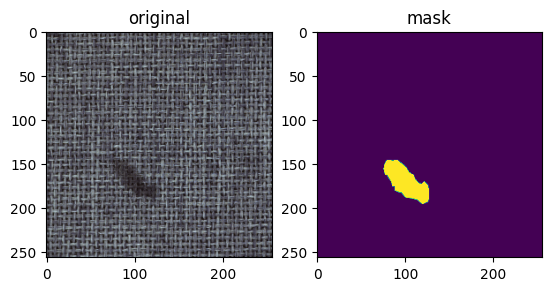

In [ ]:
sample = Test_dataset.__getitem__(1)
img, has_anomaly, mask, idx = sample.values()
print(has_anomaly)
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img.transpose(1,2,0))
plt.subplot(1,2,2)
plt.title("mask")
plt.imshow(mask.transpose(1,2,0))
plt.show()

### Set Model

In [ ]:
# ReconstructiveSubNetwork
model = ReconstructiveSubNetwork(in_channels=3, out_channels=3)
model = model.to('cuda')
model.apply(weights_init);

# DiscriminativeSubNetwork
model_seg = DiscriminativeSubNetwork(in_channels=6, out_channels=2)
model_seg = model_seg.to('cuda')
model_seg.apply(weights_init);

### Set Hyperparameters

In [ ]:
# optimizer = torch.optim.Adam([{"params": model.parameters(), "lr": lr}, {"params": model_seg.parameters(), "lr": lr}])
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[epochs*0.8,epochs*0.9],gamma=0.2, last_epoch=-1)

In [ ]:
# loss_l2 = torch.nn.modules.loss.MSELoss()
# loss_ssim = SSIM()
# loss_focal = FocalLoss()

### Re-train

In [ ]:
# 불러오고 적용하기
checkpoint = torch.load('./checkpoints/checkpoint.tar')

model.load_state_dict(checkpoint['model_state_dict'])
model_seg.load_state_dict(checkpoint['model_seg_state_dict'])

<All keys matched successfully>

In [ ]:
model = model.eval()
model_seg = model_seg.eval()

### Test

In [ ]:
normal_sample = Test_dataset.__getitem__(0)
gray_batch = torch.FloatTensor(normal_sample["image"]).unsqueeze(0).cuda()
gray_rec = model(gray_batch)
joined_in = torch.cat((gray_rec.detach(), gray_batch), dim=1)

out_mask = model_seg(joined_in)
out_mask_sm = torch.softmax(out_mask, dim=1)

In [ ]:
out_mask_sm[0,0].size()

torch.Size([2, 256, 256])

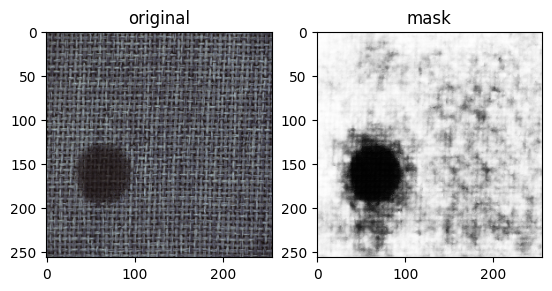

In [ ]:
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(normal_sample["image"].transpose(1,2,0))
plt.subplot(1,2,2)
plt.title("mask")
plt.imshow(out_mask_sm[0,0].detach().to('cpu'), cmap='gray')
plt.show()

In [ ]:
normal_sample = Test_dataset.__getitem__(41)
gray_batch = torch.FloatTensor(normal_sample["image"]).unsqueeze(0).cuda()
gray_rec = model(gray_batch)
joined_in = torch.cat((gray_rec.detach(), gray_batch), dim=1)

out_mask = model_seg(joined_in)
out_mask_sm = torch.softmax(out_mask, dim=1)

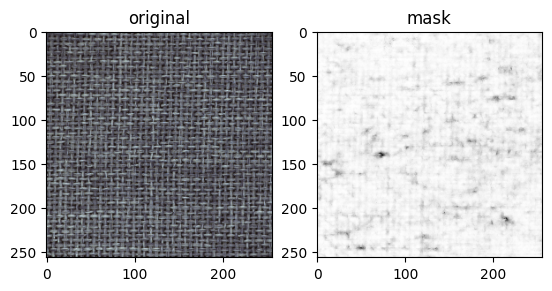

In [ ]:
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(normal_sample["image"].transpose(1,2,0))
plt.subplot(1,2,2)
plt.title("mask")
plt.imshow(out_mask_sm[0,0].detach().to('cpu'), cmap='gray')
plt.show()

### Train

In [ ]:
img_dim = 256

total_pixel_scores = np.zeros((img_dim * img_dim * len(Test_dataset)))
total_gt_pixel_scores = np.zeros((img_dim * img_dim * len(Test_dataset)))

mask_cnt = 0

anomaly_score_gt = []
anomaly_score_prediction = []

display_images = torch.zeros((16 ,3 ,256 ,256)).cuda()
display_gt_images = torch.zeros((16 ,3 ,256 ,256)).cuda()
display_out_masks = torch.zeros((16 ,1 ,256 ,256)).cuda()
display_in_masks = torch.zeros((16 ,1 ,256 ,256)).cuda()
cnt_display = 0
display_indices = np.random.randint(len(Test_dataloader), size=(16,))


In [ ]:
for i_batch, sample_batched in enumerate(tqdm(Test_dataloader)):
    gray_batch = sample_batched["image"].cuda()

    is_normal = sample_batched["has_anomaly"].detach().numpy()[0, 0] # 0, 1 정답
    anomaly_score_gt.append(is_normal)
    true_mask = sample_batched["mask"] # is_normal 1이면 zeros, 0이면 mask
    true_mask_cv = true_mask.detach().numpy()[0, :, :, :].transpose((1, 2, 0))


    gray_rec = model(gray_batch) # I_o를 reconst model에 넣어 I_r 출력
    joined_in = torch.cat((gray_rec.detach(), gray_batch), dim=1) # I_r과 I를 concat

    out_mask = model_seg(joined_in) # anomaly area mask 출력
    out_mask_sm = torch.softmax(out_mask, dim=1) # binarizatino

    # if i_batch in display_indices:
    #     t_mask = out_mask_sm[:, 1:, :, :]
    #     display_images[cnt_display] = gray_rec[0]
    #     display_gt_images[cnt_display] = gray_batch[0]
    #     display_out_masks[cnt_display] = t_mask[0]
    #     display_in_masks[cnt_display] = true_mask[0]
    #     cnt_display += 1

    out_mask_cv = out_mask_sm[0 ,1 ,: ,:].detach().cpu().numpy()


    out_mask_averaged = torch.nn.functional.avg_pool2d(out_mask_sm[: ,1: ,: ,:], 21, stride=1, padding=21 // 2).cpu().detach().numpy()
    image_score = np.max(out_mask_averaged)
    anomaly_score_prediction.append(image_score)

    flat_true_mask = true_mask_cv.flatten()
    flat_out_mask = out_mask_cv.flatten()
    total_pixel_scores[mask_cnt * img_dim * img_dim:(mask_cnt + 1) * img_dim * img_dim] = flat_out_mask
    total_gt_pixel_scores[mask_cnt * img_dim * img_dim:(mask_cnt + 1) * img_dim * img_dim] = flat_true_mask
    mask_cnt += 1


anomaly_score_prediction = np.array(anomaly_score_prediction)
anomaly_score_gt = np.array(anomaly_score_gt)
auroc = roc_auc_score(anomaly_score_gt, anomaly_score_prediction)
ap = average_precision_score(anomaly_score_gt, anomaly_score_prediction)

total_gt_pixel_scores = total_gt_pixel_scores.astype(np.uint8)
total_gt_pixel_scores = total_gt_pixel_scores[:img_dim * img_dim * mask_cnt]
total_pixel_scores = total_pixel_scores[:img_dim * img_dim * mask_cnt]
auroc_pixel = roc_auc_score(total_gt_pixel_scores, total_pixel_scores)
ap_pixel = average_precision_score(total_gt_pixel_scores, total_pixel_scores)

print("AUC Image:  " +str(auroc))
print("AP Image:  " +str(ap))
print("AUC Pixel:  " +str(auroc_pixel))
print("AP Pixel:  " +str(ap_pixel))
print("==============================")


100%|██████████| 117/117 [00:15<00:00,  7.55it/s]


AUC Image:  0.9586677367576243
AP Image:  0.9873112778023002
AUC Pixel:  0.9576935904993642
AP Pixel:  0.5731849057449322


In [ ]:
anomaly_score_prediction[anomaly_score_gt == 1].min(), anomaly_score_prediction[anomaly_score_gt == 1].max(), anomaly_score_prediction[anomaly_score_gt == 1].mean()

(0.08010929, 0.9672506, 0.5664608)

In [ ]:
anomaly_score_prediction[anomaly_score_gt == 0].min(), anomaly_score_prediction[anomaly_score_gt == 0].max(), anomaly_score_prediction[anomaly_score_gt == 0].mean()

(0.045173775, 0.34360808, 0.13528524)